# Predicting College Basketball Scores
Darren Lund  
ACME

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
import disp_functions as df # Helper Functions
plt.rcParams["figure.dpi"] = 300

## Introduction  

The art of predicting the outcome of a competition is at least as old as the ancient Roman Empire. Just as contests and competitions of skill have intrigued humankind, people have wanted to determine beforehand who the victor would be.  One of the biggest instances of this in our day and age is the NCAA March Madness (Men's College Basketball) Tournament.  A total of 68 teams coming together in a single elimination tournament to determine which college team would come out on top...and millions of fans predicting who will win each game.  This project seeks to do just that; use the seasonal data of each participating team to try and determine their success in this tournament.  

Usually, an endeavor like this takes the form of a page-rank algorithm.  Each team is ranked by the algorithm with the higher ranked team coming out on top in any contest.  While effective, it can miss certain nuances of the game and potential upsets.  The approach presented here seeks to better predict those occurances by taking two teams and obseving the individual contributions of each player to the game.  It takes the seasonal statistics of each player to try and understand the inner workings of the team: who contributed most to points scored close to the basket, who contributed most to their outside shooting, who holds the defense together, and, most importantly, what do each of these contributions have on the final score.  

To answer these questions, data was scraped directly from https://kenpom.com/, a website maintained by Ken Pomeroy, a basketball statistician.  He readily gave permission to use the data he has collected for this project.  As such, the data obtained has no reason to be skewed in any way, and should be representative of the actual numbers from the games played.  For each year from 2013 to 2017, and for every team that participated in that year's tournament, a team scouting report has been collected from that year, as well as a table for each player on the team that includes that players' statistics for each game that season.

## Data Gathering and Cleaning
Note : Due to the time consuming nature of this process, the code for this process is neither imported nor run here.  The code was written to only need running once, and so that's how many times it was run.

While the full code used for gathering and cleaning the data is given separately, a brief overview is presented here.  The first step was getting the information off Ken's website.  This was accomplished using Selenium to crawl through his site (year by year, team by team, and player by player), opening all needed webpages, then parsing the HTML through BeautifulSoup to get the desired tables.  After saving these, they were converted to csv files, and then into pandas dataframes and cleaned.  

The player data cleaning involved:  

\begin{enumerate}
    \item Removing extra HTML code from table
    \item Rename and filter columns
    \item Zeroing out certain statistics, specifically
    \begin{itemize}
        \item Games in which a player didn't play, and
        \item Hyphens used to represent a zero
    \end{itemize}
    \item Removing extra lines
\end{enumerate} 

There were eight players (DaMetrius Upchurch of NCA&T, 2013; Geoff Groselle of Creighton, 2014; Evan Wesenberg of North Dakota St., 2015; Tom Wamukota of Wichita St., 2015; Brian Greene of Florida Gulf Coast, 2016; Levan (Shizz) Alston of Temple, 2016; Ty Taylor of Wichita St., 2016; and Larry Austin of Xavier, 2016) who had two rows of statistics for a specific game, which were removed manually.  

Certain statistics were then created for each game to better understand each player's personal contribution to the offense and the defense: scoring percentage for each type of shot (two-pointers, three-pointers, and free-throws), the percentage of each shot that each player took for a specific team; the approximate number of points prevented by the player [calculated as 2*((# of blocks) + (# of steals) - (# of turnovers))] (NOTE: this number can be negative if the player gave up more potential points through turnovers than they prevented); and the margin of victory (which was negative if the team lost).

Below is the data for Nigel Williams-Goss of Gonzaga for their final 2017 game agains North Carolina.  

In [2]:
player = pd.read_csv('./DATA/2017/Gonzaga/Nigel Williams-Goss_adj')
# Everytime you save it adds an extra column of the indices,
#     so remove it
player = player.drop('Unnamed: 0',axis=1)
team = pd.read_csv('./Data/2017/Gonzaga/Scouting_Report_csv')
team = team.drop('Unnamed: 0',axis=1)

In [3]:
print(player.loc[0])

Date                   Apr 3
Opponent      North Carolina
Result              L, 71-65
OTs                      0OT
Site                 Neutral
Conference            NCAA-T
MP                        39
ORtg                      86
%Ps                       28
Pts                       15
2Pt                     4-14
3Pt                      1-3
FT                       4-8
OR                         2
DR                         7
A                          6
TO                         2
Blk                        0
Stl                        0
PF                         3
2Pt %               0.285714
3Pt %               0.333333
FT %                     0.5
2Pt %Att                0.35
3Pt %Att            0.157895
FT %Att             0.307692
Pnts-Prev                 -4
Marg                      -6
Name: 0, dtype: object


The scouting report was cleaned by:  
\begin{enumerate}
    \item Removing the "rankings" of statistics from the statistics themselves
    \item Removing superfluous symbols (such as a '+' symbol, or '%' sign)
    \item Correcting data saved differently than displayed.  For the defensive fingerprint row (which is just a string), the contents were placed in each column so that no matter what column was observed, you could obtain the information
    \item Name the columns appropriately, and finally
    \item Save the cleaned dataframe as a separate file (so that any errors could be quickly and easily corrected from the original, without needing to redownload)  
\end{enumerate}

Below is the final scouting report for Gonzaga in 2017.  

In [4]:
print(team)

                  Category     Offense     Defense    D-I Avg.
0          Adj. Efficiency       118.4        86.3       104.7
1               Adj. Tempo        70.1        70.1        68.1
2        Avg. Poss. Length        15.9        18.1        17.3
3           Effective FG%:        56.6        41.1        50.5
4              Turnover %:        16.2        17.1        18.5
5             Off. Reb. %:        30.0        26.2        29.3
6                 FTA/FGA:        39.0        26.9        35.3
7                     3P%:        38.2        29.0        35.0
8                     2P%:        56.3        40.0        49.3
9                     FT%:        71.7        65.8        70.4
10                 Block%:         7.8        11.2         9.2
11                 Steal%:         7.6         9.6         8.7
12                3PA/FGA:        32.8        32.1        36.4
13                  A/FGM:        51.8        43.2        52.4
14  Defensive Fingerprint:  Mostly Man  Mostly Man  Mos

## Analysis

For purposes of this project, analysis will be done on the 2017 championship game between Gonzaga and North Carolina.   
The first step is to determine which players will end up contributing the most to this game.  Since it's a tournament game, it's highly unlikely that everyone will play, unless the game is so far gone that the winner is already determined. The best offensive players will be determined by those who consistently attempt the most shots.  Why look only at attempts, as opposed to whoever scores the most?  Well, as basketball is a team sport, the team tends to give the ball to those who shoot best.  While anyone can have an on or off day (thus maybe having a poor shooter with a relatively high number of shots made, or a good shooter with a relatively low number), the team will consistently give opportunities to the players they trust to shoot the ball.  Not only that, but the more shot attempts a player has, the longer they likely have played in the game, and so the more likely it is that the coach trusts them to push the team to victory.  Thus, those who attempt the most shots are likely the ones who play the best, and the most likely to play for important games.  
Below is code and violin plots for the number of attempted two-point shots.  
NOTE: The first row (0) is dropped because that IS the Gonzaga-North Carolina game.

In [5]:
# Create a dictionary of the teams players
#     Values are the dataframe file
path = './DATA/2017/'
NC = df.team_dict(path,'North Carolina',drop=[0])
Gz = df.team_dict(path,'Gonzaga',drop=[0])

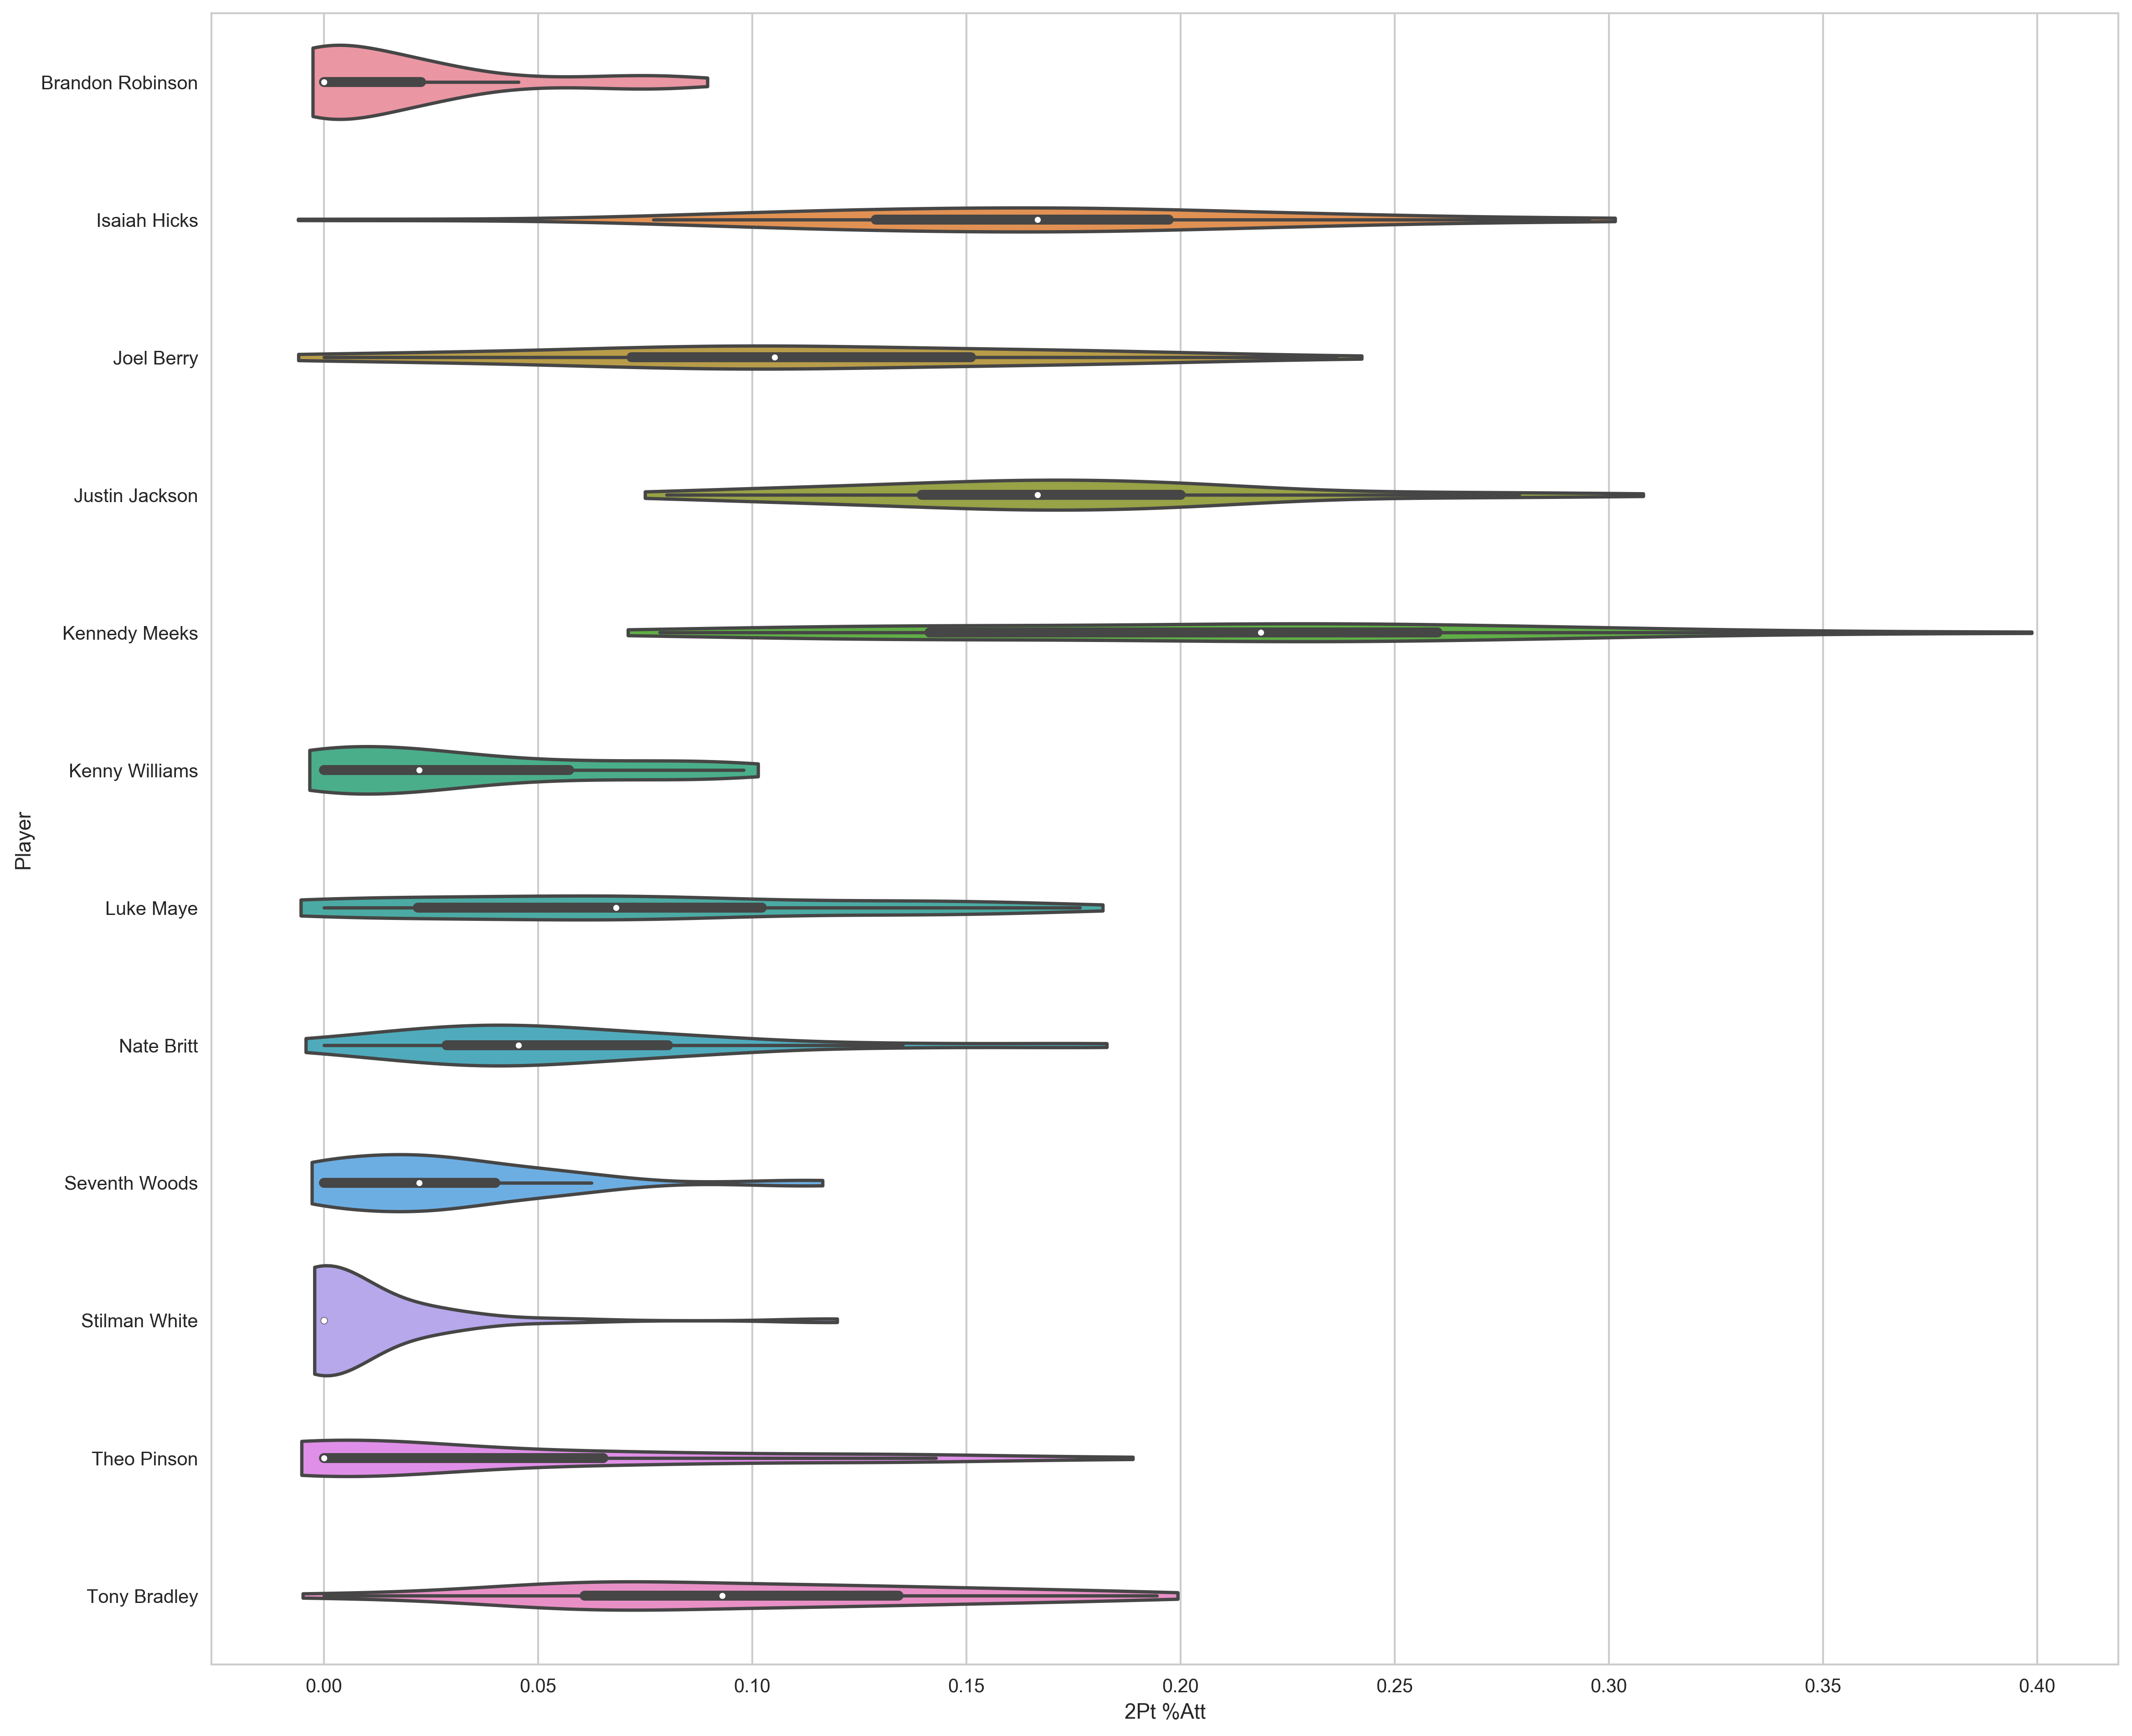

In [6]:
# Get stats for two pointers
NC_two_stats = []
NC_players = []
for player,dataframe in NC.items() :
    stats = list(dataframe['2Pt %Att'])
    player_name = len(stats)*[player]
    # Append them to lists
    for stat in stats :
        NC_two_stats.append(stat)
    for player in player_name :
        NC_players.append(player)
# Create the dataframe, then add info
NC_twos = pd.DataFrame()
NC_twos['2Pt %Att'] = NC_two_stats
NC_twos['Player'] = NC_players
# Create a violin plot for each player
sns.set_style('whitegrid')
fig = plt.figure(figsize=(18,16))
ax = sns.violinplot(x=NC_twos['2Pt %Att'],y=NC_twos['Player'],
                    data=NC_twos,order=NC.keys(),bw=.5,cut=.2)
plt.show()

These plots identify Kennedy Meeks, Isaiah Hicks, Justin Jackson, Joel Berry, Tony Bradley, and Luke Maye as players who consistently attempt the most two point shots.  Similar plots are then created for three-point shots, free-throws, and finally (for defense) points prevented.  For the sake of space they are excluded, but can be found in the Analysis and Graphing file.

Each player is assigned a point for each list to which they pertain.  Those with the highest scores should be those who are the top overall performers, with the cut-off being either eight players, or no one else scoring at least a two (whichever comes first).  In this case, for North Caronlina, that list is Justin Jackson, Isaiah Hicks, Joel Berry, Kennedy Meeks, Luke Maye, and Nate Britt.  For Gonzaga, a similar analysis lists Johnathan Williams, Nigel Williams-Goss, Jordan Mathews, Przemek Karnowski, Zach Collins, Silas Melson, and Josh Perkins.  In almost all cases, this lines up with the top contributers and role players that Ken has included on his site.

In [7]:
NC_top_players = ['Isaiah Hicks','Joel Berry','Justin Jackson',
                  'Kennedy Meeks','Luke Maye','Nate Britt',
                  'Kenny Williams']
Gz_top_players = ['Johnathan Williams','Jordan Mathews',
                  'Nigel Williams-Goss','Przemek Karnowski',
                  'Zach Collins','Silas Melson','Josh Perkins']
# Create dictionaries of the top players
NC_top = {key:value for key,value in NC.items() if key in NC_top_players}
Gz_top = {key:value for key,value in Gz.items() if key in Gz_top_players}

Now, for each of these players it's important to get their average statistics.  This way, once it's been determined approximately how many shots each team will get (from team statistics in the scouting report), those shots can be proportioned appropriately among the players most likely to take them, along with how likely the player is to make them.

In [8]:
# Create avgs dictionary
NC_avgs, NC_data = df.create_avgs(NC_top)
Gz_avgs, Gz_data = df.create_avgs(Gz_top)

In [9]:
avg_columns = ['2Pt %','3Pt %','FT %','2Pt %Att','3Pt %Att',
               'FT %Att','Pts','Pnts-Prev']
# Create team dataframes of average data
NC_avgs_data = pd.DataFrame(NC_data.T,
                            index=avg_columns,
                            columns=NC_avgs.keys())
Gz_avgs_data = pd.DataFrame(Gz_data.T,
                            index=avg_columns,
                            columns=Gz_avgs.keys())

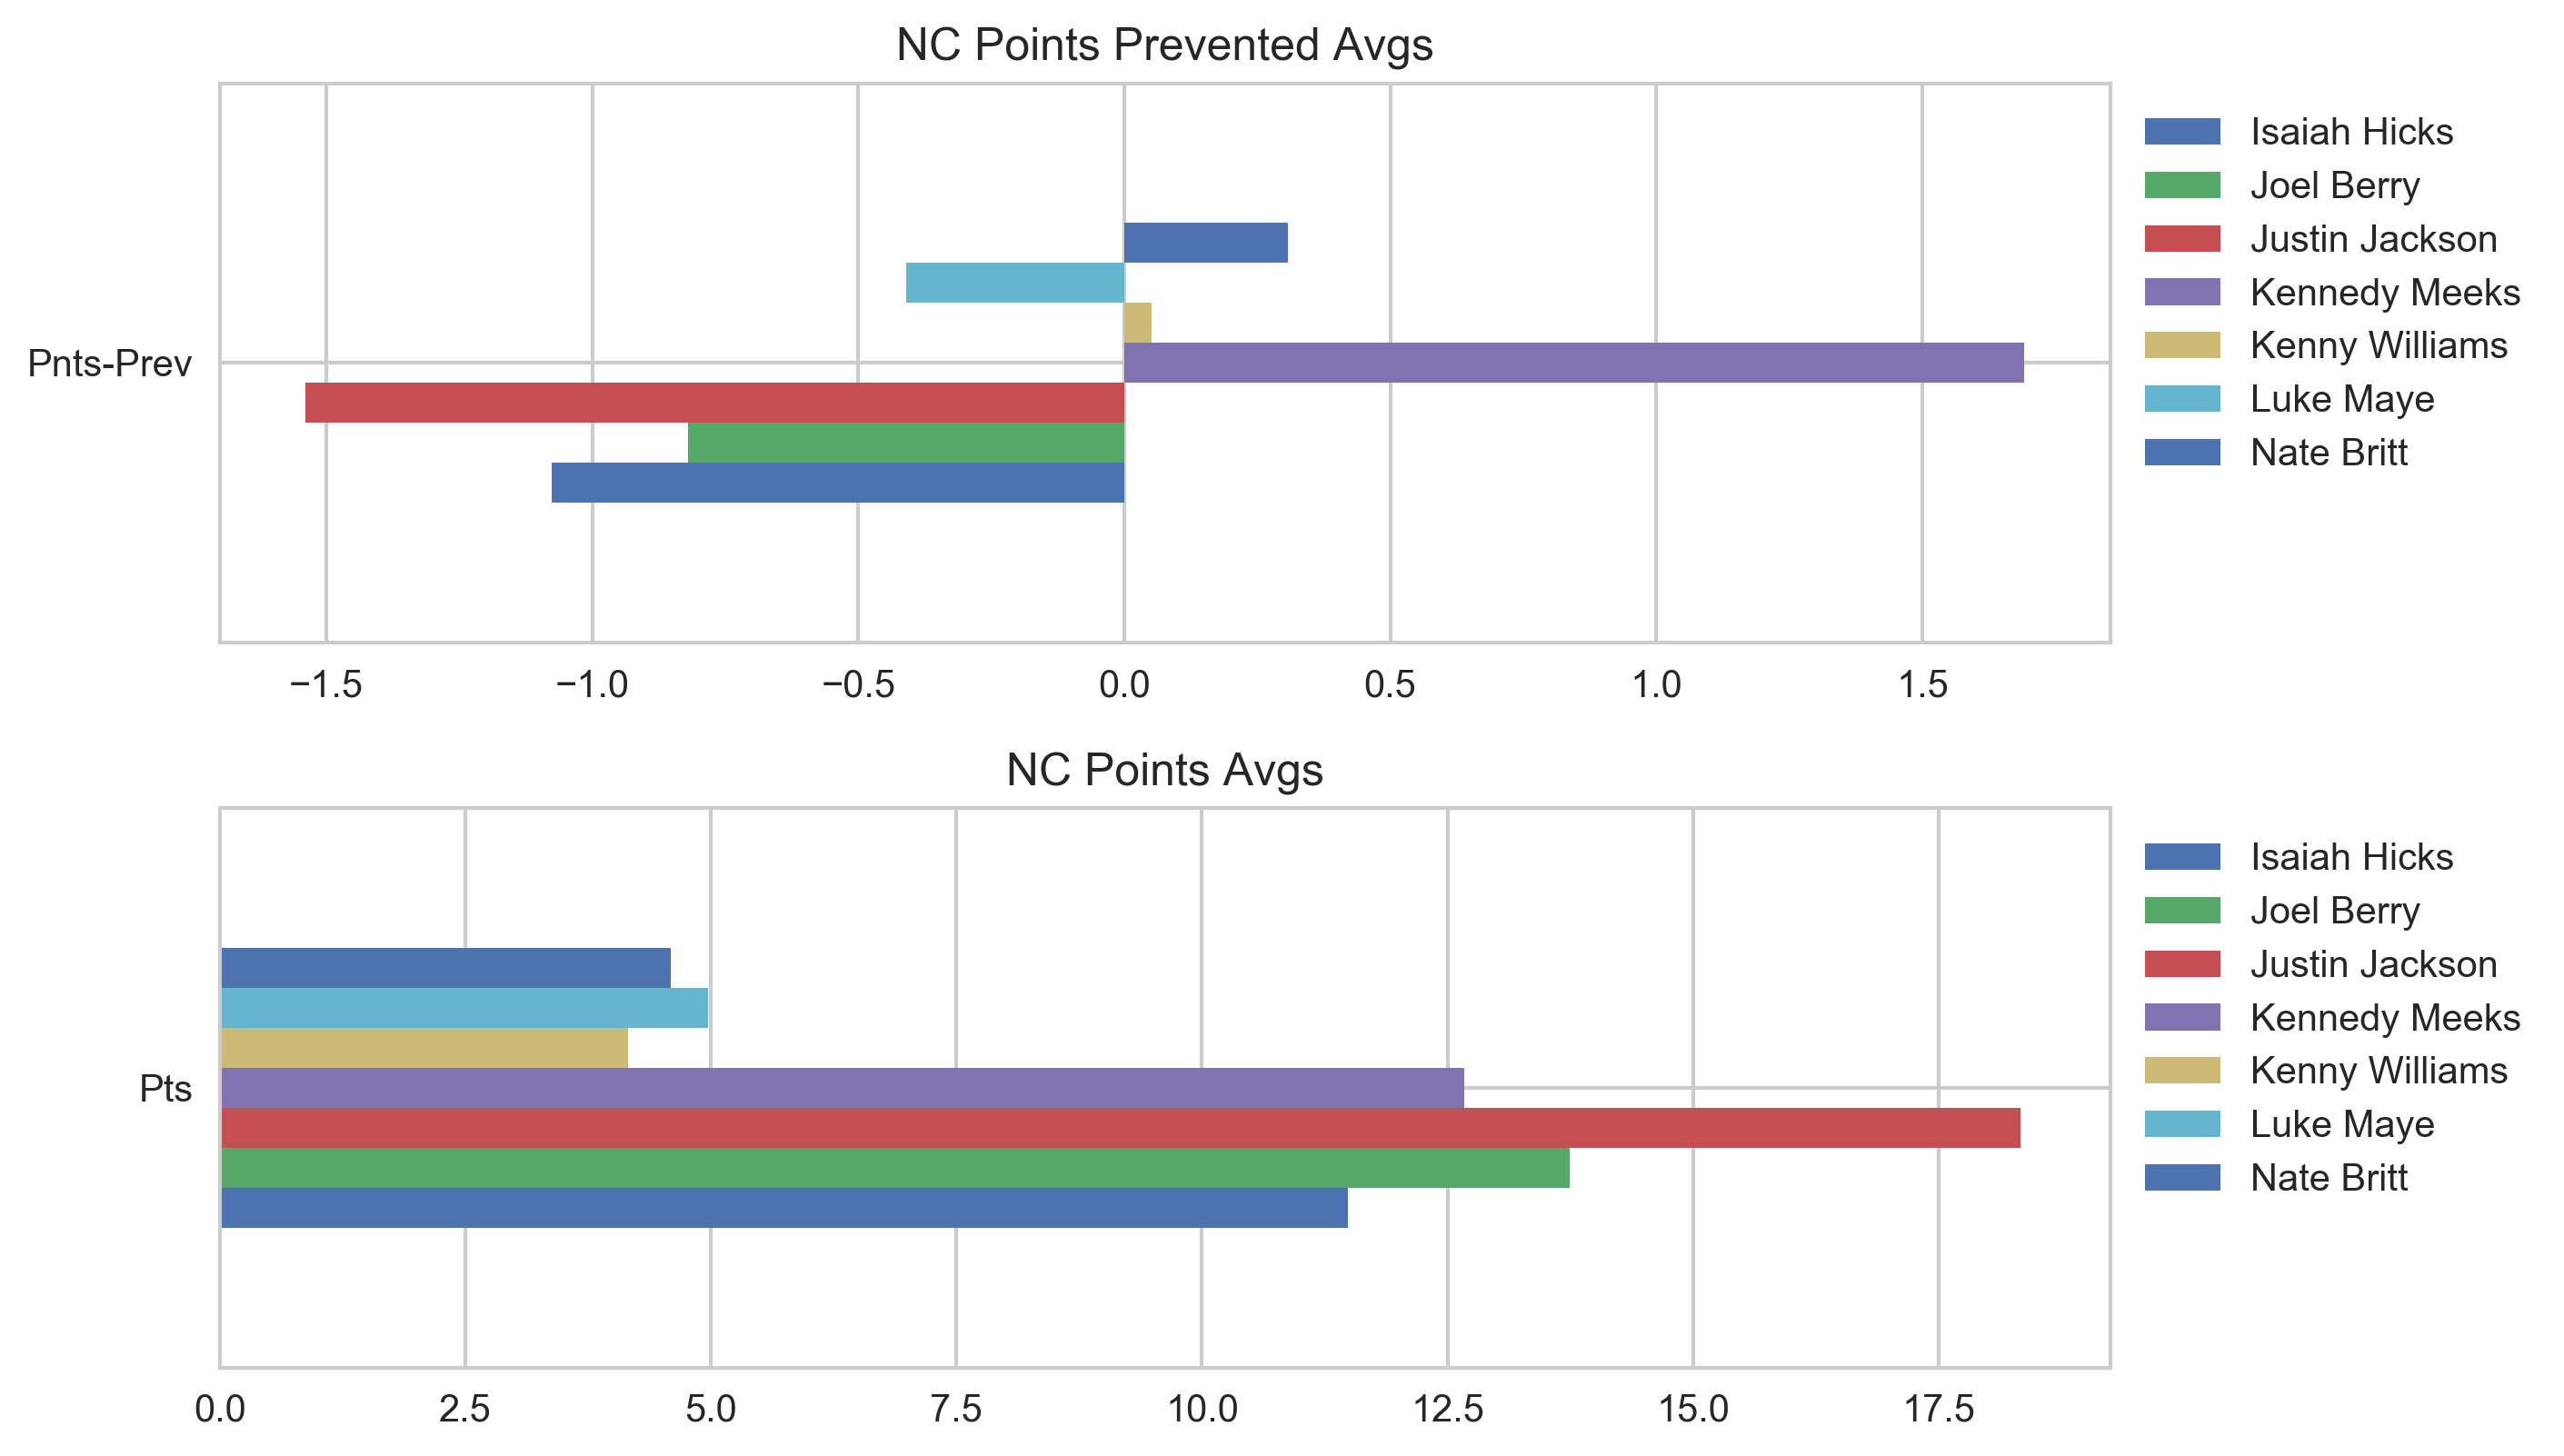

In [10]:
# Figure with 2 subplots
fig, [ax1,ax2] = plt.subplots(2, 1)
NC_pts_prevented = NC_avgs_data.drop(['2Pt %','3Pt %','FT %',
                                      'FT %Att','3Pt %Att',
                                      '2Pt %Att','Pts'])
NC_pts_prevented.plot(kind='barh',
                      title='NC Points Prevented Avgs',ax=ax1)
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
NC_pts = NC_avgs_data.drop(['2Pt %','3Pt %','FT %',
                            'FT %Att','3Pt %Att',
                            '2Pt %Att','Pnts-Prev'])
NC_pts.plot(kind='barh',title='NC Points Avgs',ax=ax2)
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

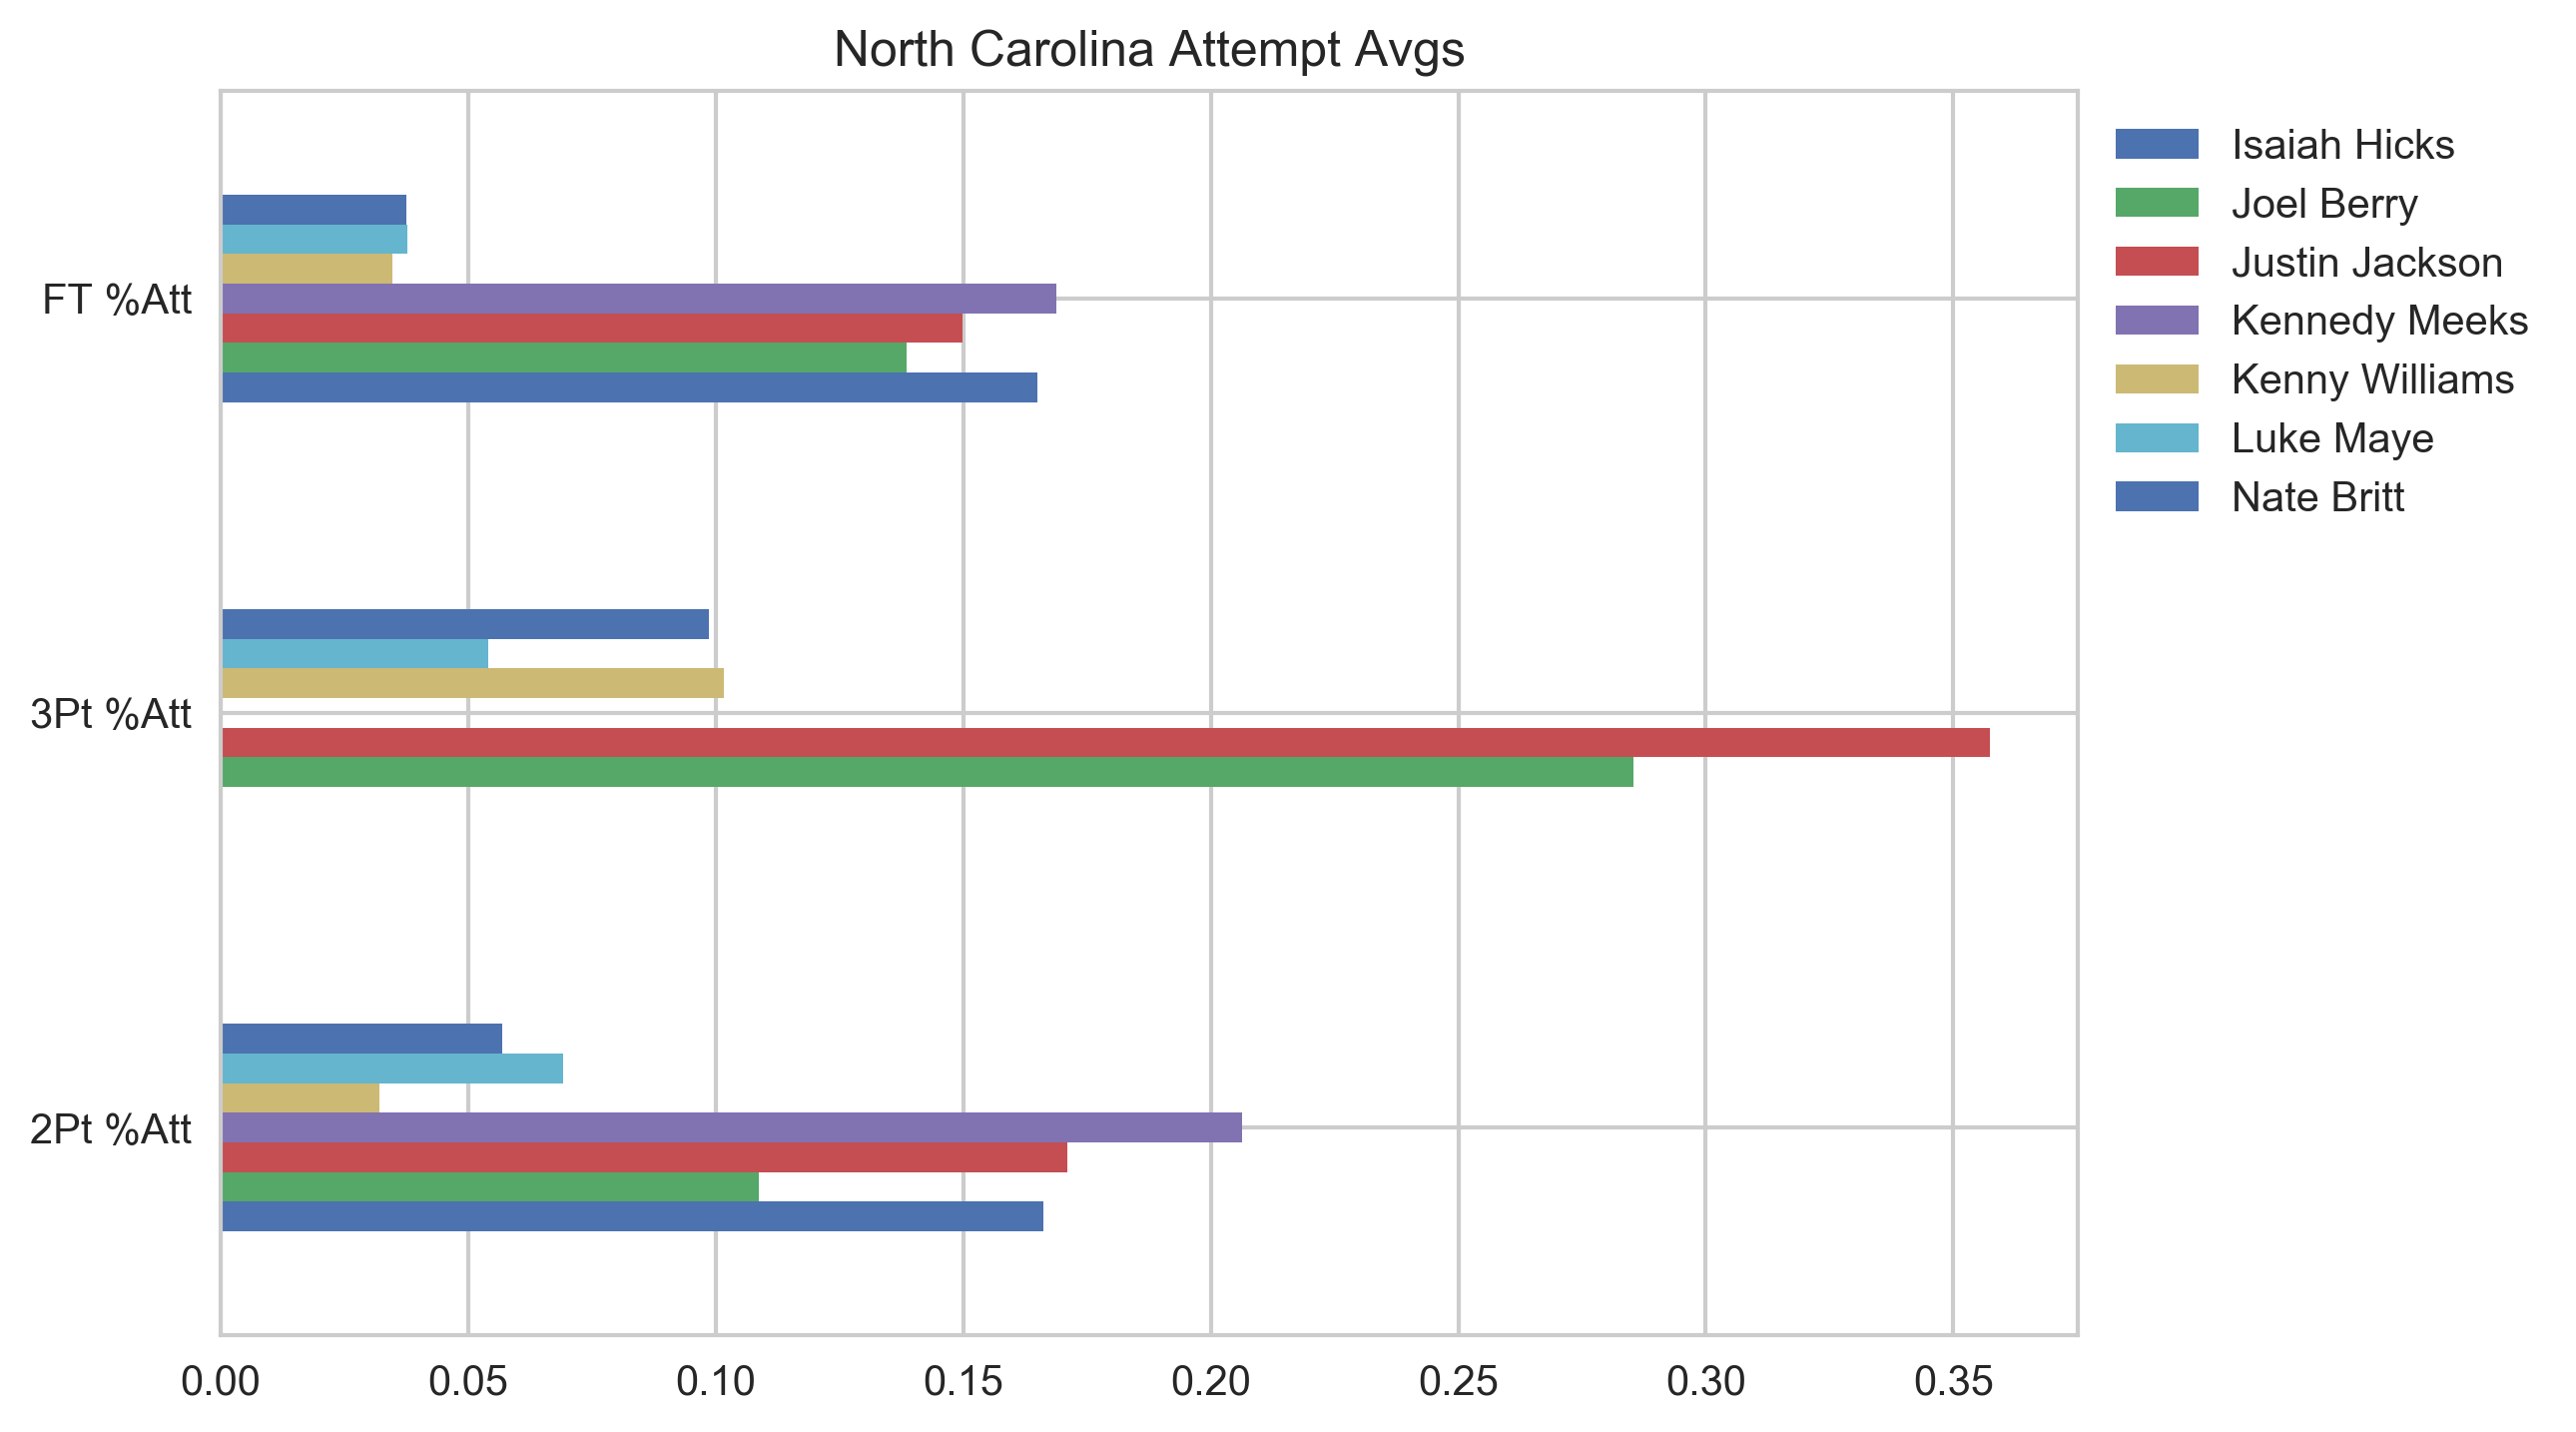

In [11]:
NC_pnts_dropped = NC_avgs_data.drop(['2Pt %','3Pt %','FT %',
                                     'Pnts-Prev','Pts'])
NC_pnts_dropped.plot(kind='barh',title='North Carolina Attempt Avgs')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()

These two bar charts indicate something about North Carolina's style of play.  They don't have the best defense, as very few of their main players consistently prevent the opposing team from scoring.  On offense, it would appear that Isaiah will consistently take two-point shots and free-throws, but never attempts a three-point shot.  He's most likely one of their centers or forwards, and only plays down low.  Justin Jackson appears to be their primary three-point shooter (helped out by Joel Berry), and Kennedy Meeks seems to to take the most inside shots (probably another center or forward).  Since most of their points seem to come from Justin Jackson and Joel Berry, it would seem like North Carolina prefers to shoot outside, as opposed to taking it inside.  However, Kennedy and Isaiah usually score well each game, constantly holding up the inside of the court.  Overall, a very balanced approach to their offense.

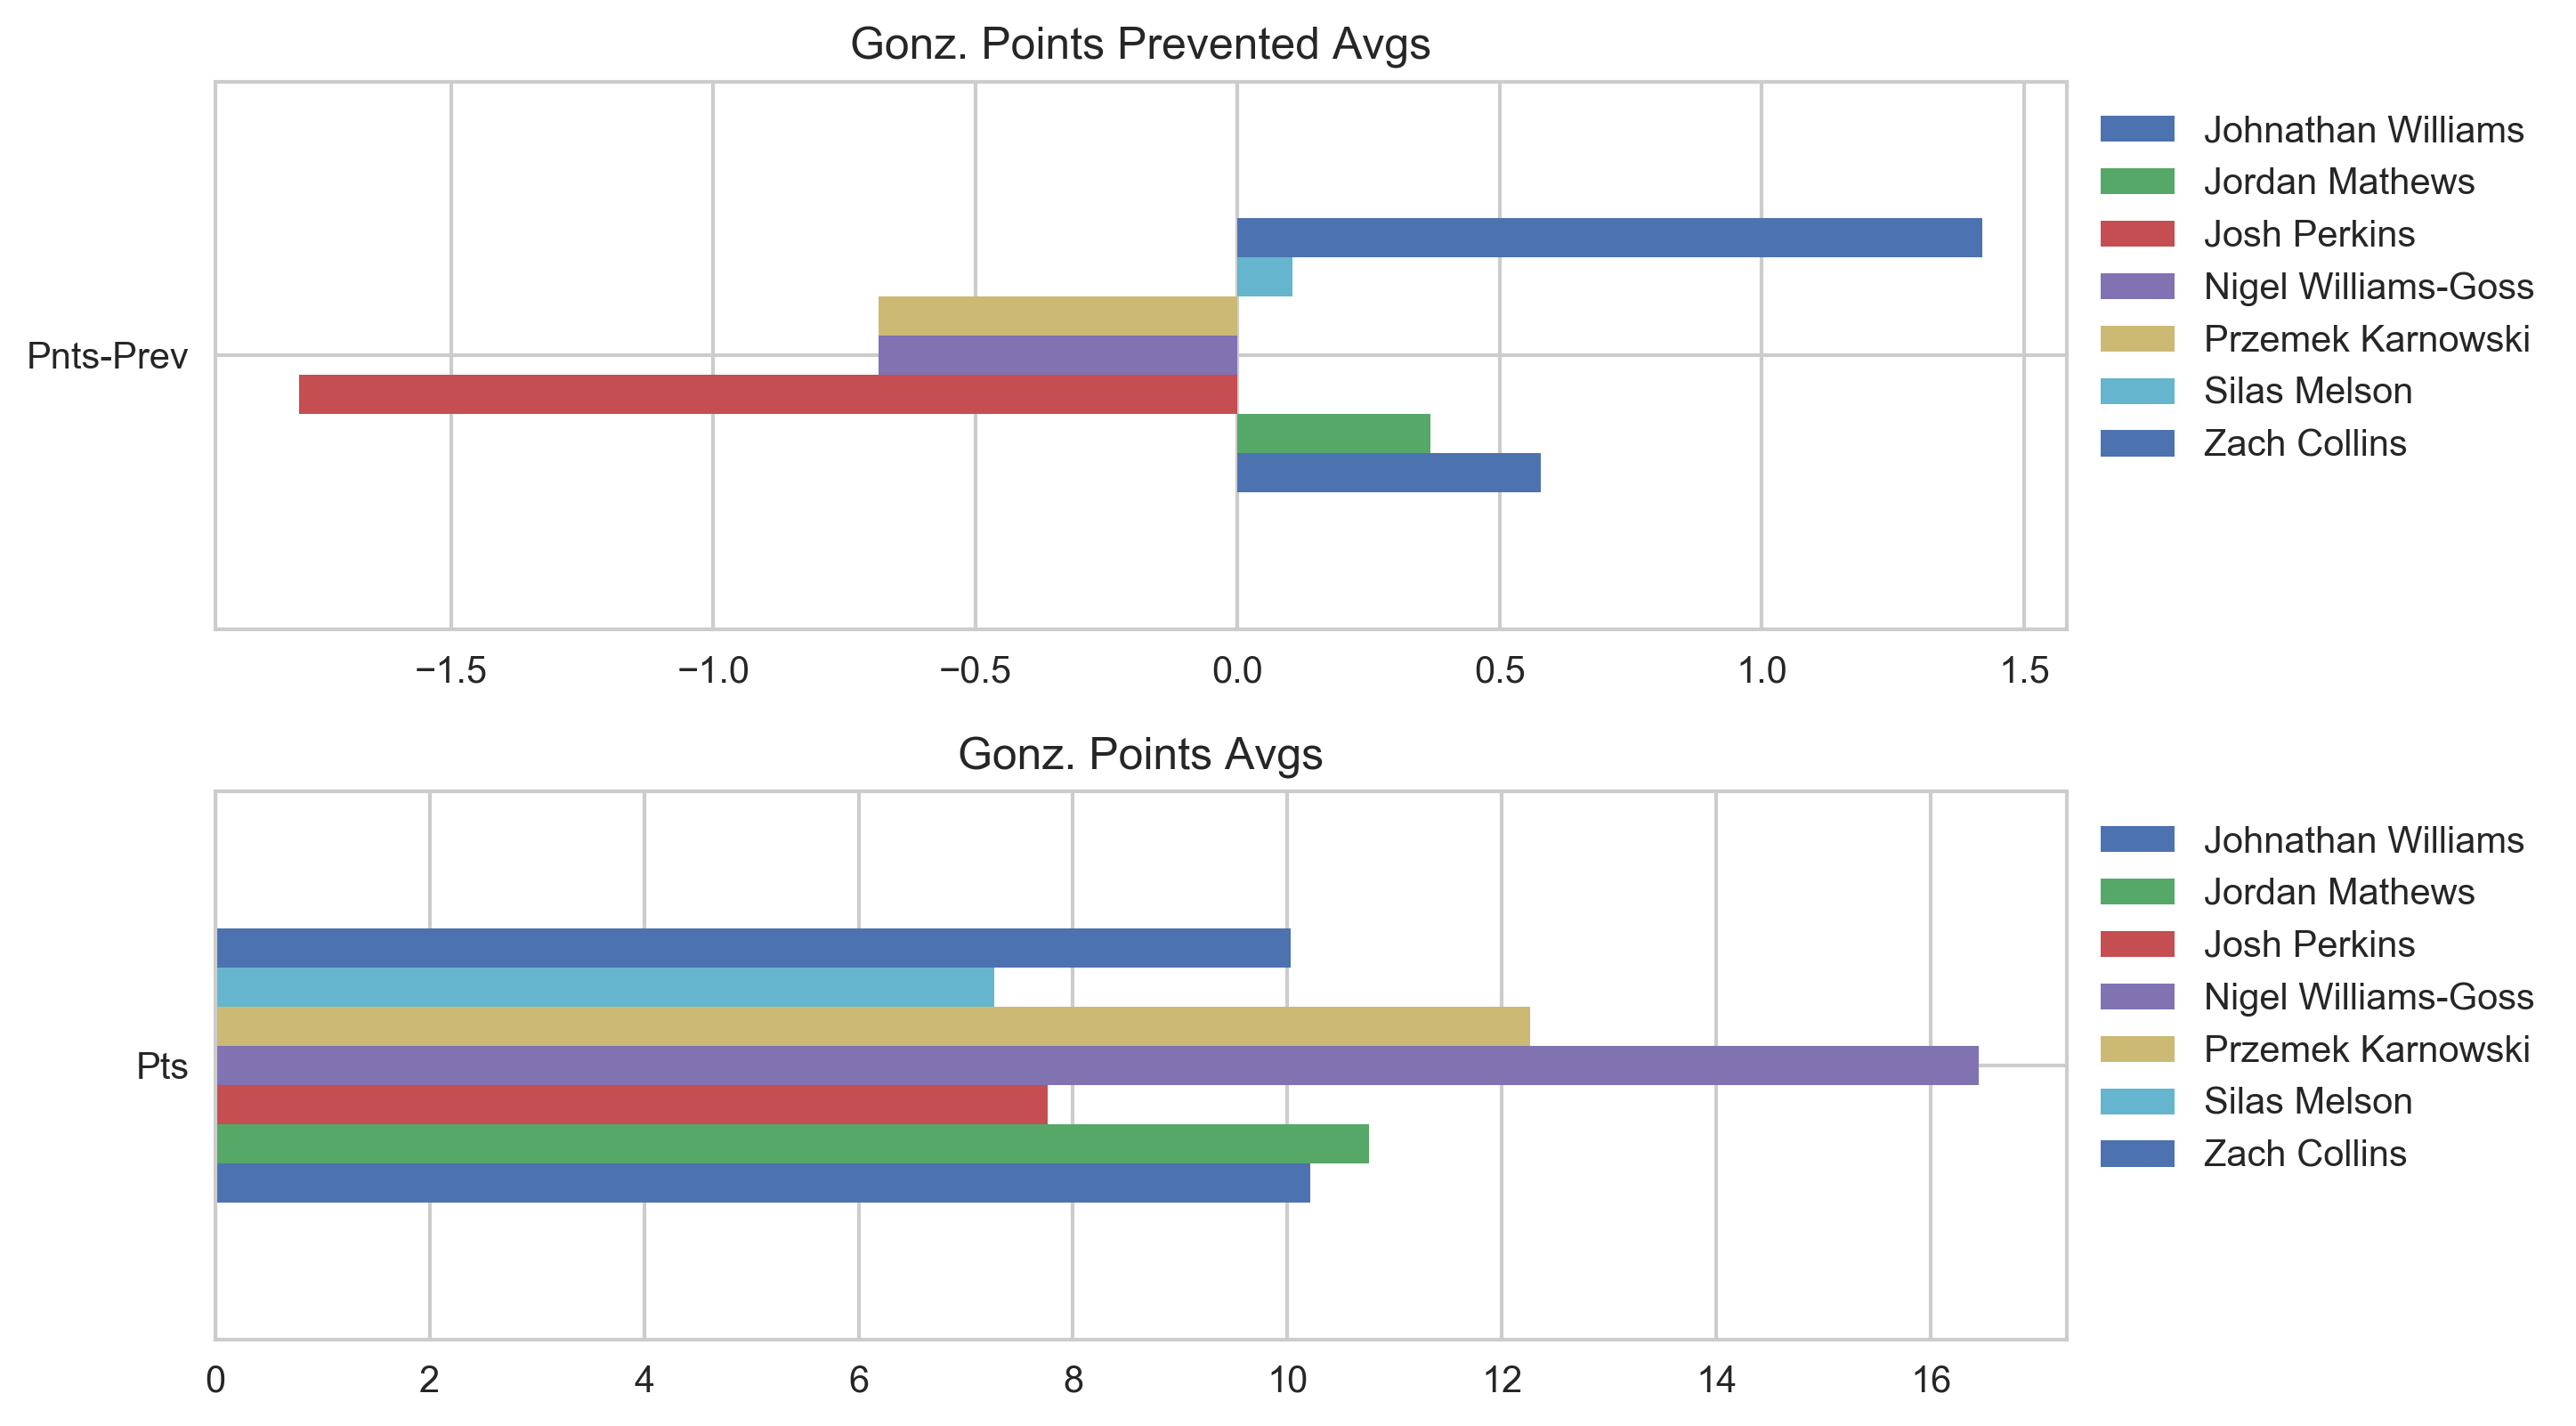

In [12]:
fig, [ax1,ax2] = plt.subplots(2, 1)
G_pts_prev = Gz_avgs_data.drop(['2Pt %','3Pt %','FT %',
                                'FT %Att','3Pt %Att',
                                '2Pt %Att','Pts'])
G_pts_prev.plot(kind='barh',
                title='Gonz. Points Prevented Avgs',ax=ax1)
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
G_pts = Gz_avgs_data.drop(['2Pt %','3Pt %','FT %',
                           'FT %Att','3Pt %Att',
                           '2Pt %Att','Pnts-Prev'])
G_pts.plot(kind='barh',title='Gonz. Points Avgs',ax=ax2)
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

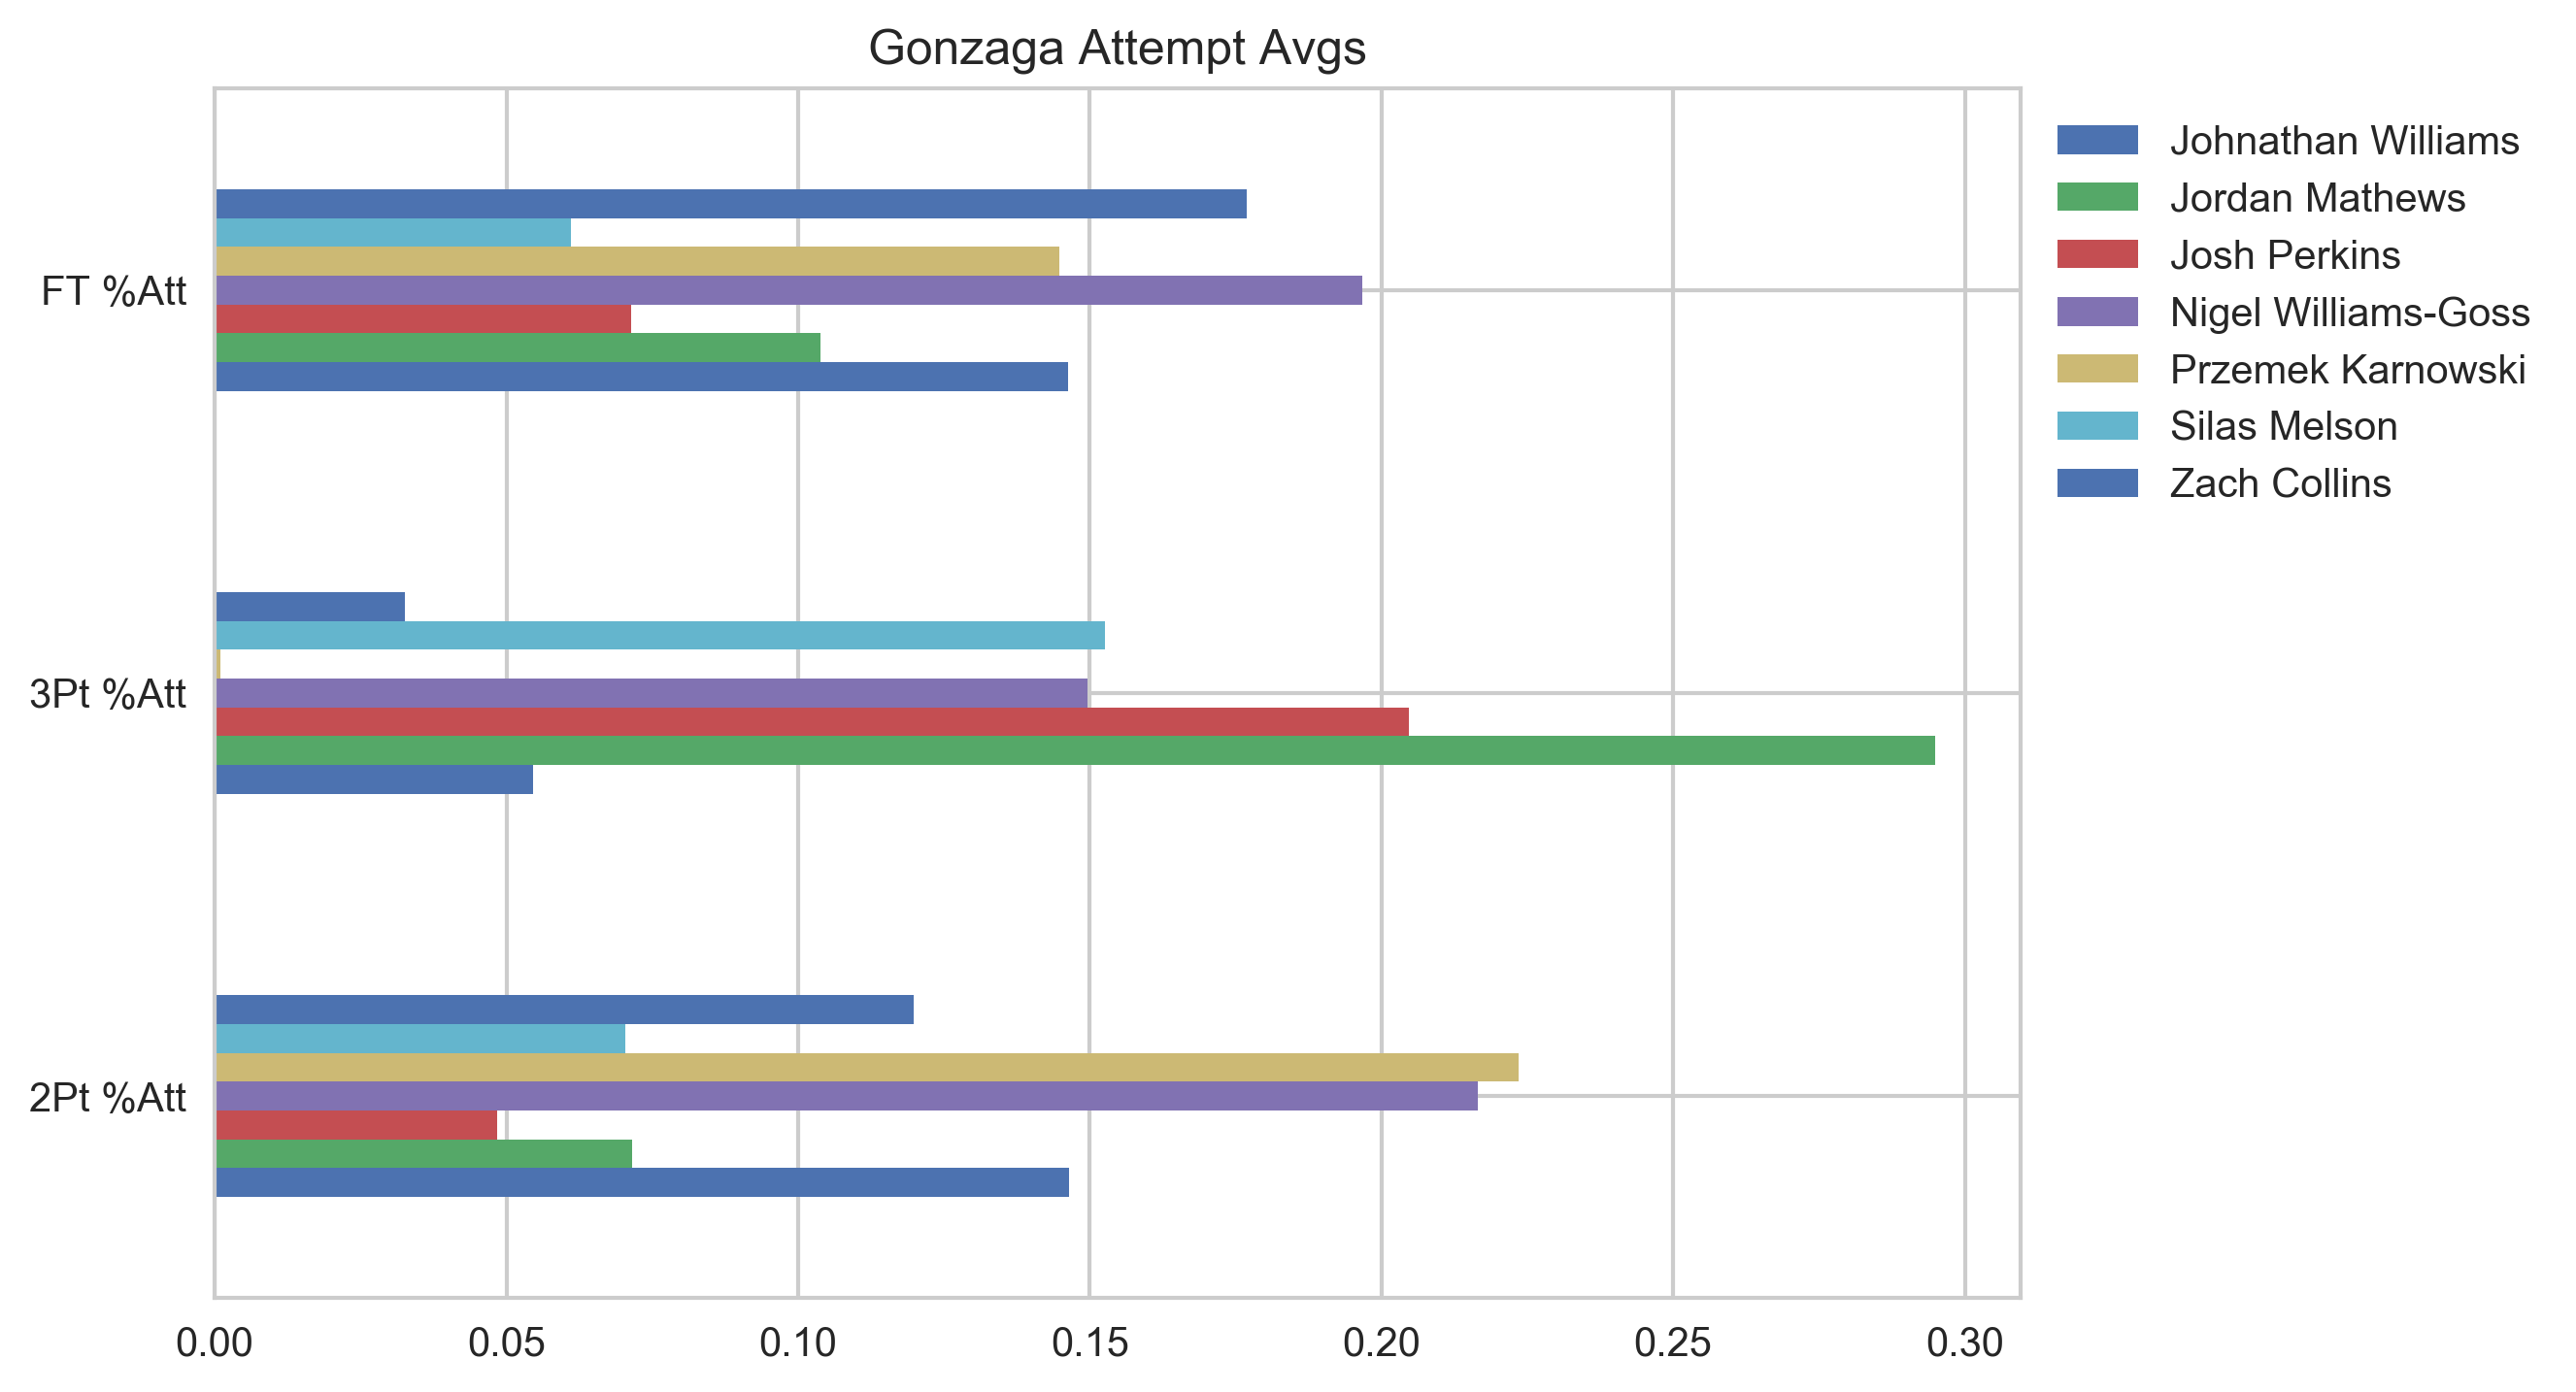

In [13]:
G_pnts_dropped = Gz_avgs_data.drop(['2Pt %','3Pt %','FT %',
                                    'Pnts-Prev','Pts'])
G_pnts_dropped.plot(kind='barh',title='Gonzaga Attempt Avgs')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()

Gonzaga appears to be a better defensive team than North Carolina, though they still give up almost as many points as their defense prevents.  As for scoring, Nigel seems to be the star, making most of the teams points from all over the court.  Helping out inside is Przemek Karnowski, who makes up the most of their inside game, together with Nigel's and Johnathan's help.  Their only real outside shooters appear to be Nigel and Jordan, but Jordan doesn't seem to make many of his attempts, as he only averages less than twelve points per game.  As such, their main style of play seems to have Nigel roaming around the court, threatening everywhere, while Przemek posts up inside, with Jordan, Johnathan, and Zach acting as supports. 

At this point, the goal is to use the scouting reports to get the average possession length of both teams offensively, and thus predict the average number of possessions each team will have during the game.  

In [14]:
# Load scouting reports and drop repeated index column
NC_scout = pd.read_csv('./DATA/2017/North Carolina/Scouting_Report_csv')
NC_scout = NC_scout.drop('Unnamed: 0',axis=1)
Gz_scout = pd.read_csv('./Data/2017/Gonzaga/Scouting_Report_csv')
Gz_scout = Gz_scout.drop('Unnamed: 0',axis=1)

In [15]:
# Find pos len [row 2]
NC_off_pos_len = float(NC_scout.loc[2]['Offense'])
NC_def_pos_len = float(NC_scout.loc[2]['Defense'])
Gz_off_pos_len = float(Gz_scout.loc[2]['Offense'])
Gz_def_pos_len = float(Gz_scout.loc[2]['Defense'])
# Average one teams offense w/ the other's defense
NC_offense = (NC_off_pos_len + Gz_def_pos_len) / 2
Gz_offense = (Gz_off_pos_len + NC_def_pos_len) / 2
# 40 minutes of gameplay -> 2400 seconds
# Allot each team time based on tempo [row 1]
time = 2400
NC_tempo = float(NC_scout.loc[1]['Offense'])
Gz_tempo = float(Gz_scout.loc[1]['Defense'])
NC_time = NC_tempo / (NC_tempo + Gz_tempo) * time
Gz_time = Gz_tempo / (NC_tempo + Gz_tempo) * time
# Get number of possessions
NC_num_poss = round(NC_time / NC_offense)
Gz_num_poss = round(Gz_time / Gz_offense)

Now, using the turnover rate for each team (turnovers they commit and turnovers they cause), the possessions that they lose the ball (and thus an opportunity to score) are removed.

In [16]:
# Get turnover percentage for each team
NC_off_turn = float(NC_scout.loc[4]['Offense'])
NC_def_turn = float(NC_scout.loc[4]['Defense'])
Gz_off_turn = float(Gz_scout.loc[4]['Offense'])
Gz_def_turn = float(Gz_scout.loc[4]['Defense'])
# Calculated Predicted turnover rate
NC_turn_over = (NC_off_turn + Gz_def_turn) / 2
Gz_turn_over = (Gz_off_turn + NC_def_turn) / 2
# Get num of scoring possessions
# Remove turnover possessions
NC_scor_poss = round(NC_num_poss*(1 - NC_turn_over / 100))
Gz_scor_poss = round(Gz_num_poss*(1 - Gz_turn_over / 100))

With this information and the distribution of how many points they get from three-point shots, two-point shots, and free-throws, the approximate number of points each player will score will be determined, and thus the approximate final score.

In [17]:
# Get distribution numbers
NC_3s = float(NC_scout.loc[15]['Offense']) / 100
NC_2s = float(NC_scout.loc[16]['Offense']) / 100
NC_ft = float(NC_scout.loc[17]['Offense']) / 100
Gz_3s = float(Gz_scout.loc[15]['Offense']) / 100
Gz_2s = float(Gz_scout.loc[16]['Offense']) / 100
Gz_ft = float(Gz_scout.loc[17]['Offense']) / 100
# Get number of possessions for each score type
NC_3_atts = round(NC_scor_poss * NC_3s)
NC_2_atts = round(NC_scor_poss * NC_2s)
NC_1_atts = round(NC_scor_poss * NC_ft)
Gz_3_atts = round(Gz_scor_poss * Gz_3s)
Gz_2_atts = round(Gz_scor_poss * Gz_2s)
Gz_1_atts = round(Gz_scor_poss * Gz_ft)
# Fix rounding error
# Since 2 pt shots are most common, add or subtract from there
NC_error = NC_3_atts + NC_2_atts + NC_1_atts - NC_scor_poss
if NC_error != 0 :
    NC_2_atts -= NC_error
Gz_error = Gz_3_atts + Gz_2_atts + Gz_1_atts - Gz_scor_poss
if Gz_error != 0 :
    Gz_2_atts -= Gz_error

Finally, we distribute these attempts amongst the team players and, using their scoring percentages, calculate how many of them they will make, and therefore how many points they will score this game.

In [18]:
# Get score distributions and points prevented
NC_scores = df.find_points(NC_avgs,NC_3_atts,NC_2_atts,NC_1_atts)
Gz_scores = df.find_points(Gz_avgs,Gz_3_atts,Gz_2_atts,Gz_1_atts)

In [19]:
# Get final scores
NC_3 = 3*(sum([NC_scores[player][0] for player in NC_scores.keys()]))
NC_2 = 2*(sum([NC_scores[player][1] for player in NC_scores.keys()]))
NC_1 = sum([NC_scores[player][2] for player in NC_scores.keys()])
Gz_3 = 3*(sum([Gz_scores[player][0] for player in Gz_scores.keys()]))
Gz_2 = 2*(sum([Gz_scores[player][1] for player in Gz_scores.keys()]))
Gz_1 = sum([Gz_scores[player][2] for player in Gz_scores.keys()])
print('NC Score: ' + str(NC_3 + NC_2 + NC_1))
print('Gz Score: ' + str(Gz_3 + Gz_2 + Gz_1))

NC Score: 65.0
Gz Score: 69.0


While these are rather close to the actual final score of the game, they are switched.  North Carolina actually won this game with a score of 71, and Gonzaga had 65.  Also, while some personal statistics are close (or exact), a fair number of them are off.  Due to spatial restrictions, the specifics are not shown here.

## Conclusion

Obviously, this method doesn't quite capture all the nuances intended.  However, as it is close to the actual final score, it appears to be a good base model for this endeavor.  Perhaps the number of offensive and defensive rebounds should be included next, or trying to predict who would foul whom, and thus improve the free throw estimates.  Similarly, this iteration didn't take into account court location.  While tournament games are played on neutral courts, is there enough leeway that a slight increase in proximity to a team's home court will give them an advantage to swing the score in their favor?  Not only that, but there were some players who performed much better than predicted (like Joel Berry).  What caused Joel to step up his game this time and perform so well? Another detail that needs to be implemented is injuries.  Throughout the season, Kenny Williams was considered a top player, and so was included as if he would play in the game.  However, he was injured for this game and didn't contribute anything.  While this data is predicted, it is unclear as to whether this will be reflected in other games.  
The nice thing is that all of these errors in specifics did manage to almost even themselves out in the overall score.  So maybe it will turn out to be impossible to predict player statistics, but the end score can be predicted this way anyways.  Whether or not this is true, it's an exciting bit of work that still remains to be done.